In [1]:
#https://www.kaggle.com/competitions/cse7512-00-dl-tp-pt1

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q '/content/drive/MyDrive/dataset/cse7512-00-dl-tp-pt1.zip' 

Checking Classes

In [3]:
import os
from pathlib import Path
directory = os.fsencode(r"cse7512-00-dl-tp-pt1/train")

for file in os.listdir(directory):
     filename = os.fsdecode(file)
     print(filename)

monkey
deer
bird
car
truck
horse
dog
ship
airplane
cat


Validation Data Creation

In [4]:

#below code is only meant to run one time

directory = os.fsencode(r"cse7512-00-dl-tp-pt1/train")
folders=[]
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     folders.append(filename)


for classer in folders:
  limit=250
  iter=0
  val_path=newpath = r"cse7512-00-dl-tp-pt1/validation/"+classer 
  os.makedirs(newpath)
  train_directory = os.fsencode(r"cse7512-00-dl-tp-pt1/train/"+classer)

  for file in os.listdir(train_directory):
    if (iter<limit):
      filename = os.fsdecode(file)
      # Move some data from training to validation folder
      Path("cse7512-00-dl-tp-pt1/train/"+classer+"/"+str(filename)).rename("cse7512-00-dl-tp-pt1/validation/"+classer +"/"+str(filename))
      iter+=1
    else:
      break


base_dir='/content/cse7512-00-dl-tp-pt1'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir=os.path.join(base_dir, 'test/test')


In [5]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=16
# this is the augmentation configuration we will use for training
shadow_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        validation_split=0.5)


shadow_in_generator = shadow_datagen.flow_from_directory(
        train_dir, 
        target_size=(96, 96),  
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        subset='training') # set as training data

shadow_out_generator = shadow_datagen.flow_from_directory(
        train_dir,
        target_size=(96, 96),  
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
         subset='validation') # set as validation data

#-----------------------------------------------------------------------
target_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        validation_split=0.5)

target_in_generator = target_datagen.flow_from_directory(
        val_dir, 
        target_size=(96, 96),  
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        subset='training') # set as training data

target_out_generator = target_datagen.flow_from_directory(
        val_dir,
        target_size=(96, 96),  
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        subset='validation') # set as validation data



Found 1250 images belonging to 10 classes.
Found 1250 images belonging to 10 classes.
Found 1250 images belonging to 10 classes.
Found 1250 images belonging to 10 classes.


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_28 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 20)                40980     
                                                                 
 activation_8 (Activation)   (None, 20)                0   

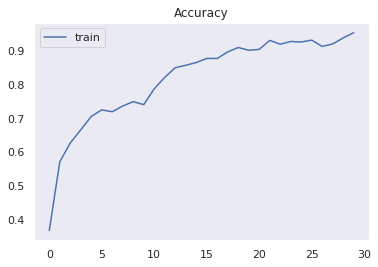

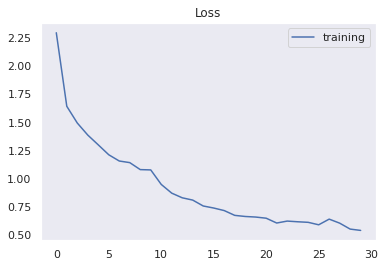

In [11]:
#Train the shadow network using the shadow in set
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Rescaling, MultiHeadAttention,BatchNormalization, Reshape
from tensorflow.keras import activations
from keras.regularizers import l2

num_classes=10
kern_1=3
kern_2=5
stri_1=1
EPOCHS=20
#---------------------------------------------------------------------------------
# transfer learning strategy----------------------------------------------------------
shadow_base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False)

shadow_base_model.trainable = False
shadow_base_model.layers.pop()

inputs = keras.Input(shape=(96,96,3))
x = shadow_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x=Dense(20,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Activation('relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(num_classes)(x)
outputs=Activation('softmax')(x)
shadow_model = keras.Model(inputs, outputs)

shadow_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
shadow_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="categorical_crossentropy",metrics=['accuracy'])
shadow_model.summary()

shadow_history=shadow_model.fit(
        shadow_in_generator,
        steps_per_epoch=1250 // batch_size,
        epochs=10,
        # validation_split=0.2,
        # validation_steps=1250 // batch_size,
        callbacks=[callback]
        )


acc1 = shadow_history.history['accuracy']

loss1 = shadow_history.history['loss']

shadow_base_model.trainable = True

shadow_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
shadow_history=shadow_model.fit(
        shadow_in_generator,
        steps_per_epoch=1250 // batch_size,
        epochs=20,
        # validation_plit=0.2
        # validation_steps=500 // batch_size,
        callbacks=[callback]
        )


acc2 = shadow_history.history['accuracy']
loss2 = shadow_history.history['loss']
#---------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Apply the default theme
sns.set_theme()

plt.figure()
acc = acc1+acc2

loss = loss1+loss2


epochs = range(len(acc))

plt.plot(epochs, acc,label='train')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss,label='training')
plt.title('Loss')
plt.grid()
plt.legend()



79/79 [==============================] - 3s 44ms/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 100, 1)      2           ['input_12[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 100, 1)      7169        ['layer_normalization_2[0][0]',  
 eadAttention)                                                    'layer_normalization_2[0][0]']  
                                      

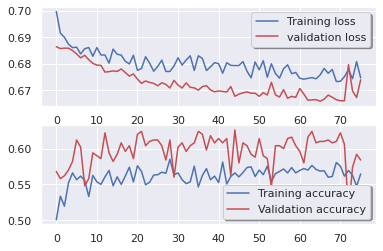

In [16]:
#Train the attack network using the outputs of the shadow in and shadow out set when sent through the shadow network.
#X1,Y1--->shadow in
#X2,Y2--->shadow out
# I see that whole success of this attack is reliant on generalizability of attack network,
#  since current training is independent of testing of target model

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Flatten,Permute
import numpy as np

#shuffler
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


shadow_Y1=shadow_model.predict(shadow_in_generator)
shadow_Y2=shadow_model.predict(shadow_out_generator)
bin_Y1=np.ones((len(shadow_Y1),1))
bin_Y2=np.zeros((len(shadow_Y2),1))
#vstack shadow_Y1 and shadow_Y2
shadow_Y=np.vstack((shadow_Y1,shadow_Y2))
#vstack bin_Y1 and bin_Y2
bin_Y=np.vstack((bin_Y1,bin_Y2))

#shuffle shadow_Y and bin_Y
shadow_Y,bin_Y=unison_shuffled_copies(shadow_Y, bin_Y)
shadow_Y=np.expand_dims(shadow_Y, axis=-1)

#spline interpolation
dil_fact=10
omega=1
A=0.1
from scipy import interpolate
shadow_Y_inter=np.zeros((shadow_Y.shape[0],shadow_Y.shape[1]*dil_fact,shadow_Y.shape[2]))
for i in range(shadow_Y.shape[0]):
    for j in range(shadow_Y.shape[2]):
        signal=shadow_Y[i,:,j]
        time=np.linspace(0, len(signal), num=len(signal), endpoint=True)
        time_new = np.linspace(0, len(signal), num=dil_fact*len(signal), endpoint=True)
        f = interpolate.interp1d(time, signal, kind='cubic')
        sn=f(time_new)
        shadow_Y_inter[i,:,j]=sn+A*np.sin(omega*2*np.pi*sn/np.max(sn))
        # shadow_Y_inter[i,:,j]=sn


#---------------------------------------------------------------------------------

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)



input_shape = shadow_Y_inter.shape[1:]
attack_model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=32,
    num_transformer_blocks=1,
    mlp_units=[10],
    mlp_dropout=0.2,
    dropout=0.1,
)



#---------------------------------------------------------------------------------
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
attack_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="binary_crossentropy",metrics=['acc'])
attack_model.summary()
history_attack = attack_model.fit(
    shadow_Y_inter, bin_Y, batch_size=32, epochs=100,validation_split=0.2,callbacks=[callback],verbose=0
)
#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history_attack.history['loss'], color='b', label="Training loss")
ax[0].plot(history_attack.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_attack.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_attack.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)




Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_34 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 20)                40980     
                                                                 
 activation_10 (Activation)  (None, 20)                0   

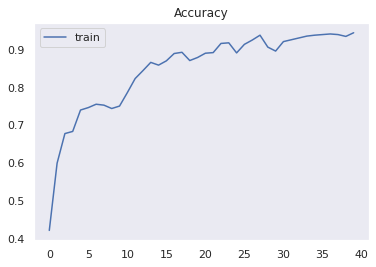

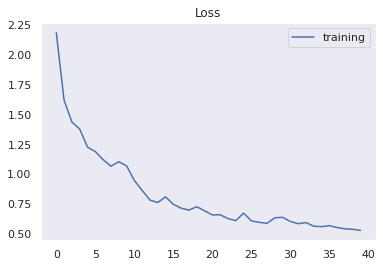

In [17]:
#Train the target network using the target in set

num_classes=10
kern_1=3
kern_2=5
stri_1=1
EPOCHS=30
#---------------------------------------------------------------------------------
# transfer learning strategy----------------------------------------------------------
target_base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False)

target_base_model.trainable = False
target_base_model.layers.pop()

inputs = keras.Input(shape=(96,96,3))
x = target_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x=Dense(20,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Activation('relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(num_classes)(x)
outputs=Activation('softmax')(x)
target_model = keras.Model(inputs, outputs)

target_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
target_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="categorical_crossentropy",metrics=['accuracy'])
target_model.summary()

target_history=target_model.fit(
        target_in_generator,
        steps_per_epoch=1250 // batch_size,
        epochs=10,
        # validation_split=0.2,
        # validation_steps=1250 // batch_size,
        callbacks=[callback]
        )


acc1 = target_history.history['accuracy']

loss1 = target_history.history['loss']

target_base_model.trainable = True

target_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
target_history=target_model.fit(
        target_in_generator,
        steps_per_epoch=1250 // batch_size,
        epochs=EPOCHS,
        # validation_plit=0.2
        # validation_steps=500 // batch_size,
        callbacks=[callback]
        )


acc2 = target_history.history['accuracy']
loss2 = target_history.history['loss']
#---------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Apply the default theme
sns.set_theme()

plt.figure()
acc = acc1+acc2

loss = loss1+loss2


epochs = range(len(acc))

plt.plot(epochs, acc,label='train')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss,label='training')
plt.title('Loss')
plt.grid()
plt.legend()



79/79 [==============================] - 0s 4ms/step
-------------------------------------------------------------------
Accuracy: 0.5948
Precision: 0.6390225017011193
Recall: 0.8768
F1 score: 0.6839313572542902


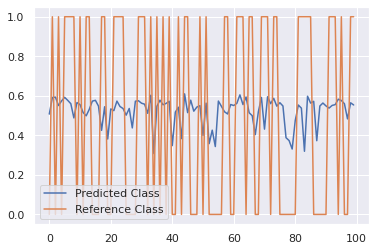

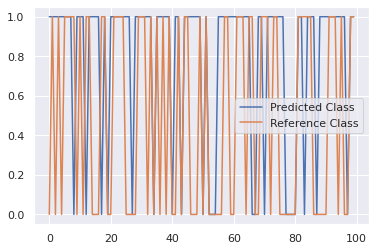

In [21]:
#Test the attack network using the outputs of the target in and target out set when sent through the target network.
#X3,Y3--->target in
#X4,Y4--->target out

target_Y3=target_model.predict(target_in_generator)
target_Y4=target_model.predict(target_out_generator)
bin_Y3=np.ones((len(target_Y3),1))
bin_Y4=np.zeros((len(target_Y4),1))
#vstack target_Y3 and target_Y4
target_Y=np.vstack((target_Y3,target_Y4))
#vstack bin_Y3 and bin_Y4
bin2_Y=np.vstack((bin_Y3,bin_Y4))

#shuffle target_Y and bin2_Y
target_Y,bin2_Y=unison_shuffled_copies(target_Y, bin2_Y)
target_Y=np.expand_dims(target_Y, axis=-1)

#spline interpolation
dil_fact=10
omega=1
A=0.1
from scipy import interpolate
target_Y_inter=np.zeros((target_Y.shape[0],target_Y.shape[1]*dil_fact,target_Y.shape[2]))
for i in range(target_Y.shape[0]):
    for j in range(target_Y.shape[2]):
        signal=target_Y[i,:,j]
        time=np.linspace(0, len(signal), num=len(signal), endpoint=True)
        time_new = np.linspace(0, len(signal), num=dil_fact*len(signal), endpoint=True)
        f = interpolate.interp1d(time, signal, kind='cubic')
        sn=f(time_new)
        target_Y_inter[i,:,j]=sn+A*np.sin(omega*2*np.pi*sn/np.max(sn))
        # shadow_Y_inter[i,:,j]=sn



bin2_Y_pred=attack_model.predict(target_Y_inter)

#binarize bin2_Y_pred
bin2_Y_pred_star=np.copy(bin2_Y_pred)
bin2_Y_pred=np.where(bin2_Y_pred>0.5,1,0)
print("-------------------------------------------------------------------")
#calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:",round(accuracy_score(bin2_Y, bin2_Y_pred),10))
#calculate the precision
from sklearn.metrics import precision_score
print("Precision:",precision_score(bin2_Y.astype(int), bin2_Y_pred.astype(int),average='macro'))
#calculate the recall
from sklearn.metrics import recall_score
print("Recall:",recall_score(bin2_Y, bin2_Y_pred))
#calculate the f1 score
from sklearn.metrics import f1_score
print("F1 score:",f1_score(bin2_Y, bin2_Y_pred))    


#plot bin2_Y_pred and bin2_Y
till=100
plt.figure()
plt.plot(bin2_Y_pred_star[:till])
plt.plot(bin2_Y[:till])
plt.legend(['Predicted Class','Reference Class'])
plt.show()

plt.figure()
plt.plot(bin2_Y_pred[:till])
plt.plot(bin2_Y[:till])
plt.legend(['Predicted Class','Reference Class'])
plt.show()

In [30]:
test_labels=[]
for i in range(0,int(1250/16)+1):
    test_labels.extend(np.array(target_in_generator[i][0]))

In [32]:
test_labels=np.array(test_labels)
test_labels.shape

(1250, 96, 96, 3)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_34 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 20)                40980     
                                                                 
 activation_10 (Activation)  (None, 20)                0   

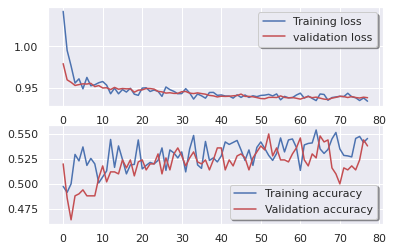

In [34]:
from keras.models import Model
target_model.trainable=False
layer_name = 'dropout_11'
x = layers.Dense(10, activation="tanh")(target_model.get_layer(layer_name).output)
o=layers.Dense(1, activation="sigmoid")(x)
mollified_target_model= Model(inputs=target_model.input, outputs=[o])


see_X3=[]
for i in range(0,int(1250/16)+1):
    see_X3.extend(np.array(target_in_generator[i][0]))
see_X3=np.array(see_X3)

see_X4=[]
for i in range(0,int(1250/16)+1):
    see_X4.extend(np.array(target_out_generator[i][0]))
see_X4=np.array(see_X4)

bin_Y3=np.ones((1250,1))
bin_Y4=np.zeros((1250,1))
#vstack see_X3 and see_X4
see_X=np.vstack((see_X3,see_X4))
#vstack bin_Y3 and bin_Y4
bin2_Y=np.vstack((bin_Y3,bin_Y4))
#shuffle see_X and bin2_Y
see_X,bin2_Y=unison_shuffled_copies(see_X, bin2_Y)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mollified_target_model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="binary_crossentropy",metrics=['acc'])
mollified_target_model.summary()
history_target_mol = mollified_target_model.fit(
    see_X, bin2_Y, batch_size=32, epochs=100,validation_split=0.2,verbose=0,callbacks=[callback]
)
#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history_target_mol.history['loss'], color='b', label="Training loss")
ax[0].plot(history_target_mol.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_target_mol.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_target_mol.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



bin2_Y_pred_mollified=mollified_target_model.predict(see_X)
#binarize bin2_Y_pred_mollified
bin2_Y_pred_mollified_star=np.copy(bin2_Y_pred_mollified)
bin2_Y_pred_mollified_star=np.where(bin2_Y_pred_mollified_star>0.55,1,0)


#calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:",round(accuracy_score(bin2_Y, bin2_Y_pred_mollified_star),10))
#calculate the precision
from sklearn.metrics import precision_score
print("Precision:",precision_score(bin2_Y, bin2_Y_pred_mollified_star))
#calculate the recall
from sklearn.metrics import recall_score
print("Recall:",recall_score(bin2_Y, bin2_Y_pred_mollified_star))
#calculate the f1 score
from sklearn.metrics import f1_score
print("F1 score:",f1_score(bin2_Y, bin2_Y_pred_mollified_star))